In [1]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import models
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# import PIL
# import PIL.Image as Image

import matplotlib.pyplot as plt

import numpy as np

# import datetime

# import cv2

import os

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%load_ext tensorboard

Tensorboard overview can be found at the end of the file

In [2]:
# # Clear any logs from previous runs
# rm -rf notebooks/logs/

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4000 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [6]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [7]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

<h3><strong>Transfer Learning v2</strong><h3>

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# train_path = "C:/MakeAIWork2/projects/apple_disease_classification/data/Train"
# valid_path = "C:/MakeAIWork2/projects/apple_disease_classification/data/Test"

# train_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path, target_size = (224, 224), batch_size = 30)
# valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(valid_path, target_size = (224, 224), batch_size = 20)

# train_generator = test_ds
# valid_generator = val_ds

# https://www.youtube.com/watch?v=DElZ6sn3ADI&t=656s

In [11]:
size = (224, 224)

train_ds_tl = train_ds.map(lambda x, y : (tf.image.resize (x, size), y))
val_ds_tl = val_ds.map(lambda x, y : (tf.image.resize (x, size), y))
test_ds_tl = test_ds.map(lambda x, y : (tf.image.resize (x, size), y))

<h3><strong>Build the model</strong></h3>

Load the pretrained model and add a Dense layer to adjust to our classification of the apples

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

#load pretrained weights and remove last layer, which will be replaced by below:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(4, activation='softmax') (x)

# last lays should correspond to number of classes: 4

model=Model(inputs=base_model.input, outputs=preds)

Pretrained layers need to frozen

In [13]:
# check the model so far
# model.summary()

# Trainable parameters: 3,044,484 (non-trainable: 34,112)

In [14]:
for layers in model.layers[:-5]:
    layers.trainable = False

In [15]:
# check the 'new 'model' with frozen layers
# model.summary()

# Result is a lot less trainable parameters: 820,612 (+ non-trainable: 2,257,984)

Compile and fit the model

In [16]:
EPOCHS = 30
optimizer = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_ds_tl, validation_data=val_ds_tl, epochs=EPOCHS)

Epoch 1/30
100/100 [==============================] - 25s 127ms/step - loss: 0.8486 - accuracy: 0.6359 - val_loss: 0.5389 - val_accuracy: 0.8000
Epoch 2/30
100/100 [==============================] - 13s 120ms/step - loss: 0.5081 - accuracy: 0.8047 - val_loss: 0.4001 - val_accuracy: 0.8537
Epoch 3/30
100/100 [==============================] - 13s 119ms/step - loss: 0.3271 - accuracy: 0.8803 - val_loss: 0.2107 - val_accuracy: 0.9212
Epoch 4/30
100/100 [==============================] - 13s 120ms/step - loss: 0.2570 - accuracy: 0.9003 - val_loss: 0.1875 - val_accuracy: 0.9425
Epoch 5/30
100/100 [==============================] - 15s 128ms/step - loss: 0.2008 - accuracy: 0.9266 - val_loss: 0.1570 - val_accuracy: 0.9425
Epoch 6/30
100/100 [==============================] - 15s 127ms/step - loss: 0.1810 - accuracy: 0.9303 - val_loss: 0.1221 - val_accuracy: 0.9563
Epoch 7/30
100/100 [==============================] - 16s 134ms/step - loss: 0.1158 - accuracy: 0.9578 - val_loss: 0.0642 - val_ac

In [17]:
scores_tl2 = model.evaluate(test_ds_tl)

4/4 [==============================] - 1s 278ms/step - loss: 3.9407 - accuracy: 0.4917


In [18]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models_trained/{model_version}")

INFO:tensorflow:Assets written to: ../models_trained/20\assets


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']

val_loss = history.history['val_loss']

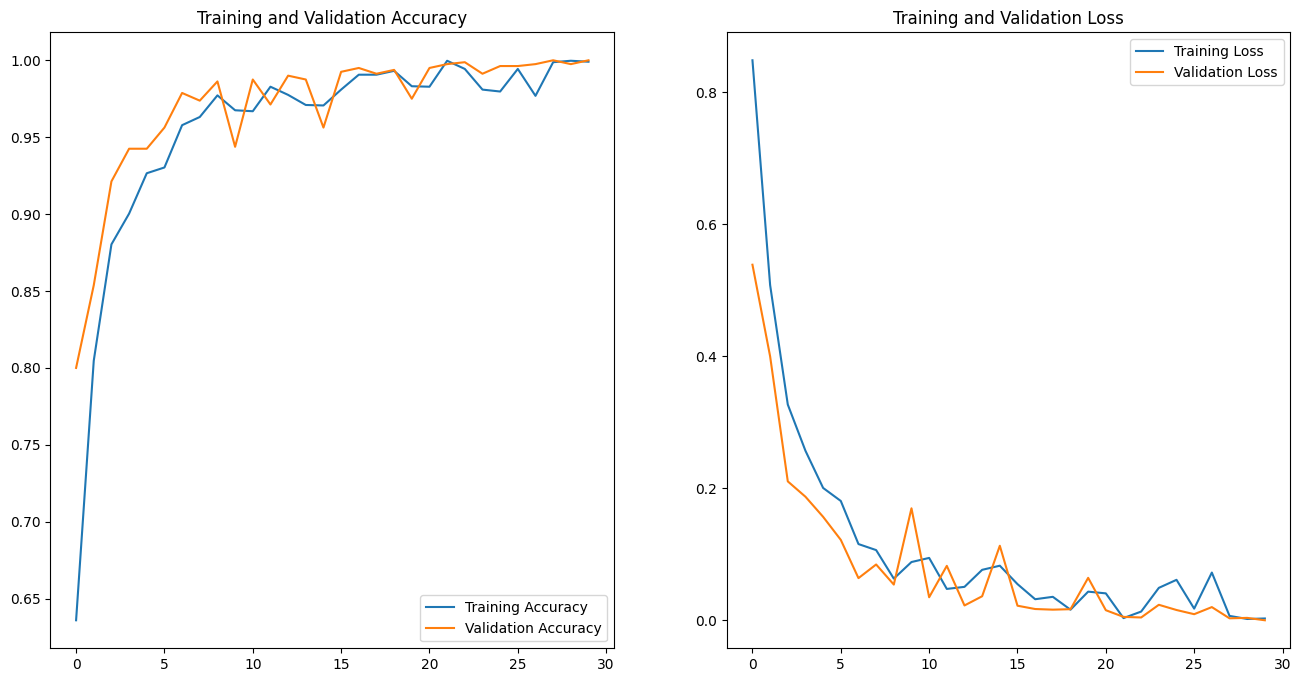

In [32]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Found 120 files belonging to 4 classes.


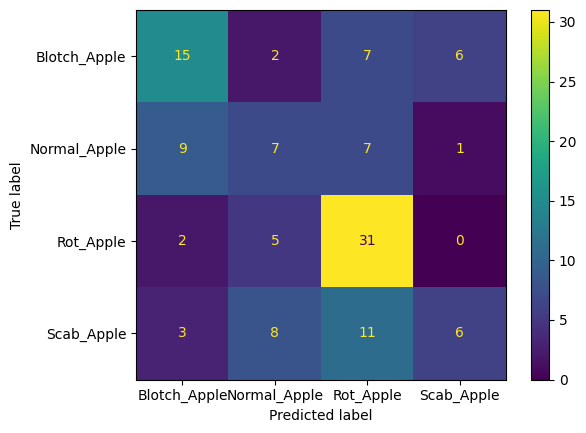

In [31]:
test_ds_tl = tf.keras.utils.image_dataset_from_directory(     # CHECK, CHECK
      "../augmented_data/Test",
      shuffle=False,
      image_size=(224, 224),
      batch_size = BATCH_SIZE 
      )

# test_label = test_ds_tl.class_names

# print(test_label)

batchPredictions = model.predict(test_ds_tl)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds_tl], axis=0)

result_confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result_confusion_matrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cm_display.plot()
plt.show()

First image to predict
First image's actual label: Normal_Apple
Predicted label: Scab_Apple
[5.0968444e-03 5.1013591e-05 6.2021608e-03 9.8864996e-01]


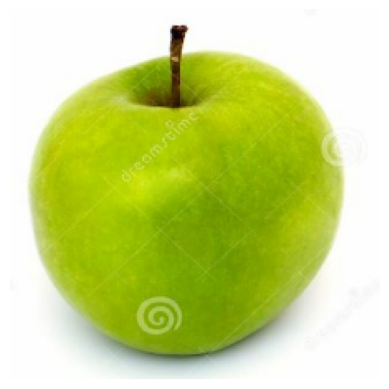

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    print(batch_prediction[0]) # input for np.argmax() above

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

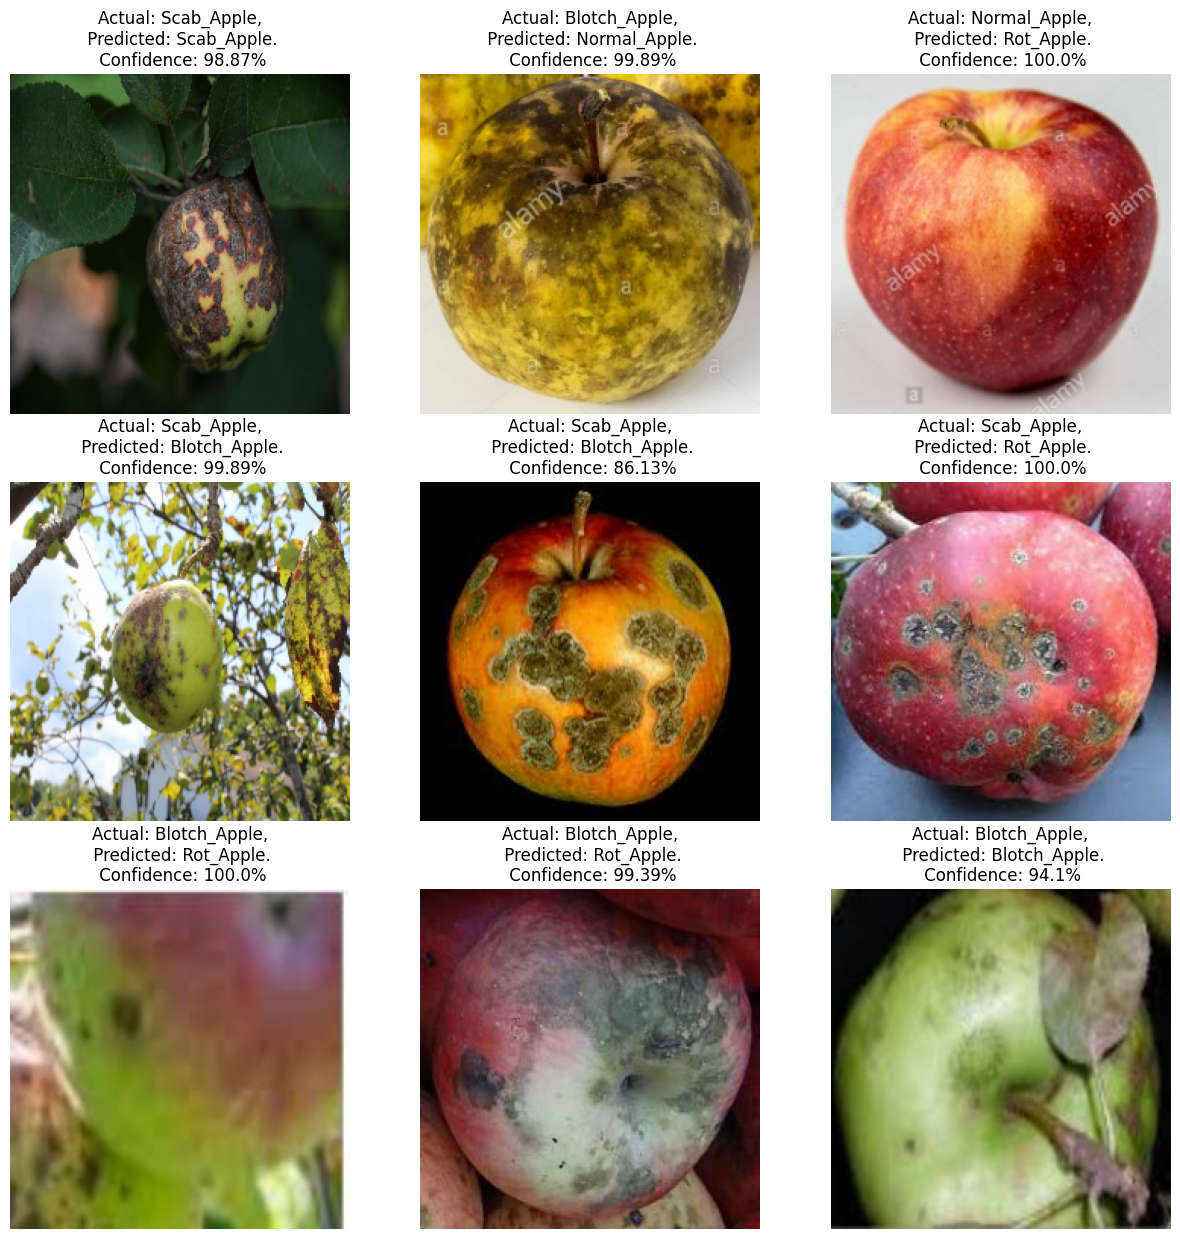

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")    